Mount Drive


In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! pip install BorutaShap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


Imports and pre-processing

In [2]:
from BorutaShap import BorutaShap
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
import seaborn as sns
sns.set()
def preprocess_data(df):
  # Save indexing features
  idxrs = df[['player_name', 'kickoff_time', 'season', 'GW']]
  # Drop indexing features
  df = df.drop(columns = ['player_name', 'kickoff_time', 'season', 'GW'])
  # Binary encoding
  for col in df.columns:
    df[col] = df[col].replace({True:1, False:0})
  # One hot encodings
  ohe_cols = []
  for col in df.select_dtypes(include='object').drop(columns = ['FDR']).columns:
      ohe_cols.append(col)
  df = pd.get_dummies(df, columns=ohe_cols, prefix=ohe_cols)
  mapping = {'Low': 0, 'Medium': 1, 'Hard':2}
  df['FDR'] = df['FDR'].map(lambda x : mapping[x])
  # Restore indexing features
  df['kickoff_time'] = idxrs['kickoff_time']
  df['GW'] = idxrs['GW']
  return df

def get_training_data(GW, scale = True, drop_cat = True):
    # df = pd.read_csv('./drive/MyDrive/Data/rollbacked_us.csv')
    df = pd.read_csv('C://Users//jd-vz//Desktop//Code//data//rollbacked_us.csv')
    if drop_cat:
      # df.drop(['team', 'opponent_team'], inplace = True, axis = 1) # No relationship obeserved - remove for comp. exp.
      df = preprocess_data(df) 
    min_date = df[(df['GW'] == GW) & (df['kickoff_time'] >= '2020-08-12')]['kickoff_time'].min() # The first date of the gameweek
    max_date = df[(df['GW'] == GW) & (df['kickoff_time'] > '2020-08-12')]['kickoff_time'].max() # The last date of the gameweek
    df_scl = df[df['kickoff_time'] <= max_date].copy() 
    std_x, std_y = StandardScaler(), StandardScaler()
    scaled_cols = []
    if scale:
      for col in df.columns.drop(['total_points', 'kickoff_time']):
        if df[col].nunique() > 2:
          scaled_cols.append(col)
      df_scl[scaled_cols] = std_x.fit_transform(df_scl[scaled_cols])
      df_scl['total_points'] = std_y.fit_transform(df_scl['total_points'].to_numpy().reshape(-1, 1))
      df_train, df_test = df_scl[df_scl['kickoff_time'] < min_date], df_scl[df_scl['kickoff_time'] >= min_date] 
      X = df_train.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y = df_train['total_points']
      X_val = df_test.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y_val = df_test['total_points']
      return X, X_val, y, y_val, std_x, std_y
    else:
      df_train, df_test = df_scl[df_scl['kickoff_time'] < min_date], df_scl[df_scl['kickoff_time'] >= min_date] 
      X = df_train.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y = df_train['total_points']
      X_val = df_test.drop(['total_points', 'kickoff_time', 'GW'], axis = 1)
      y_val = df_test['total_points']
      return X, X_val, y, y_val

X_train, X_test, y_train, y_test, std_x, std_y = get_training_data(GW = 1, scale = True)

Feature Selection Using BorutaShap

  0%|          | 0/100 [00:00<?, ?it/s]

FOLD 1/4


100%|██████████| 100/100 [07:04<00:00,  4.24s/it]


35 attributes confirmed important: ['minutes_shift_rolling_2_mean', 'bonus_shift_rolling_17_sum', 'FDR', 'team_win_perc_shift_rolling_16_sum', 'creativity_shift_rolling_17_mean', 'win_shift_rolling_17_sum', 'influence_shift_rolling_36_mean', 'team_score_shift_rolling_17_sum', 'xGChain_shift_rolling_16_mean', 'opponent_team_Other', 'position_GK', 'shots_shift_rolling_12_mean', 'premium_players_Budget', 'saves_shift_rolling_9_sum', 'selected', 'threat_shift_rolling_22_mean', 'xA_shift_rolling_17_mean', 'played_67_shift_rolling_15_mean', 'common_transfer_rolling_9_sum', 'team_Other', 'assists_shift_rolling_25_sum', 'xG_shift_rolling_34_mean', 'premium_players_Premium', 'position_DMID', 'ict_index_shift_rolling_34_mean', 'form_shift_rolling_29_mean', 'was_home', 'xGBuildup_shift_rolling_16_sum', 'substitution', 'position_location_Right', 'position_location_General', 'value', 'npxG_shift_rolling_34_mean', 'goals_scored_shift_rolling_35_mean', 'bps_shift_rolling_36_mean']
56 attributes confi

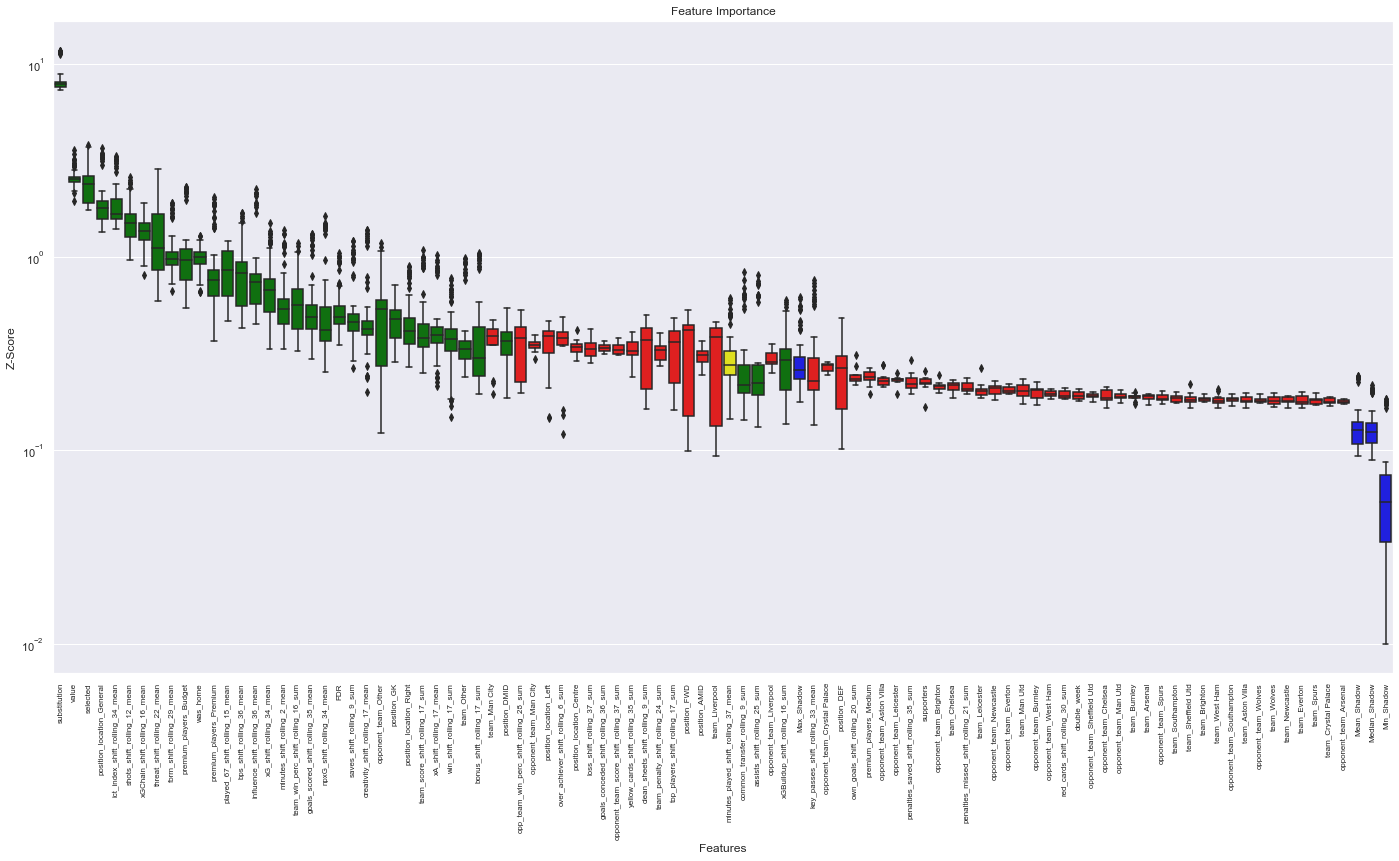

  0%|          | 0/100 [00:00<?, ?it/s]

Selected features at fold 1 are: ['FDR', 'assists_shift_rolling_25_sum', 'bonus_shift_rolling_17_sum', 'bps_shift_rolling_36_mean', 'common_transfer_rolling_9_sum', 'creativity_shift_rolling_17_mean', 'form_shift_rolling_29_mean', 'goals_scored_shift_rolling_35_mean', 'ict_index_shift_rolling_34_mean', 'influence_shift_rolling_36_mean', 'minutes_shift_rolling_2_mean', 'npxG_shift_rolling_34_mean', 'opponent_team_Other', 'played_67_shift_rolling_15_mean', 'position_DMID', 'position_GK', 'position_location_General', 'position_location_Right', 'premium_players_Budget', 'premium_players_Premium', 'saves_shift_rolling_9_sum', 'selected', 'shots_shift_rolling_12_mean', 'substitution', 'team_Other', 'team_score_shift_rolling_17_sum', 'team_win_perc_shift_rolling_16_sum', 'threat_shift_rolling_22_mean', 'value', 'was_home', 'win_shift_rolling_17_sum', 'xA_shift_rolling_17_mean', 'xGBuildup_shift_rolling_16_sum', 'xGChain_shift_rolling_16_mean', 'xG_shift_rolling_34_mean']
FOLD 2/4


 42%|████▏     | 42/100 [02:52<04:07,  4.26s/it]

In [4]:
# Define parameters (use n_estimators = 100)
params = {'max_depth': 5,
          'max_features': 'sqrt',
          'criterion': 'mse'}
# Define folds
folds = 4 
skf = KFold(n_splits=folds, shuffle=True, random_state=0)
selected_columns = list()
# Repeat algorithm for folds
for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"FOLD {k+1}/{folds}")
    
    model = RandomForestRegressor(random_state=0, **params, n_jobs = 8)
    Feature_Selector = BorutaShap(model=model,
                                  importance_measure='shap', 
                                  classification=False)
    
    Feature_Selector.fit(X=X_train.iloc[train_idx, :], y=y_train[train_idx], n_trials=100, random_state=0) 
    Feature_Selector.plot(which_features='all', figsize=(24,12), save_name=f'bshap_save_{k}.pdf')
    Feature_Selector.results_to_csv(filename=f'C://Users//jd-vz//Desktop//Code//bshap_{k}')
    selected_columns.append(sorted(Feature_Selector.Subset().columns))
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")
final_selection = sorted({item for selection in selected_columns for item in selection})
pd.DataFrame({'feat':final_selection}).to_csv('C://Users//jd-vz//Desktop//Code//borutashap.csv', index = False) # Save results

Investigate Points Scored

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


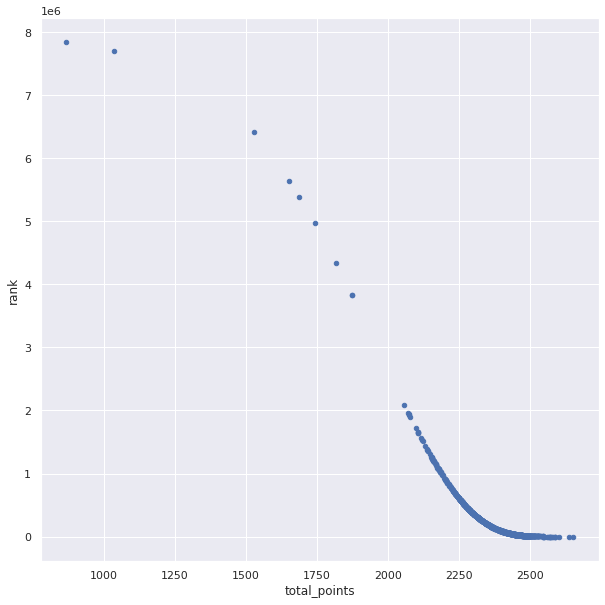

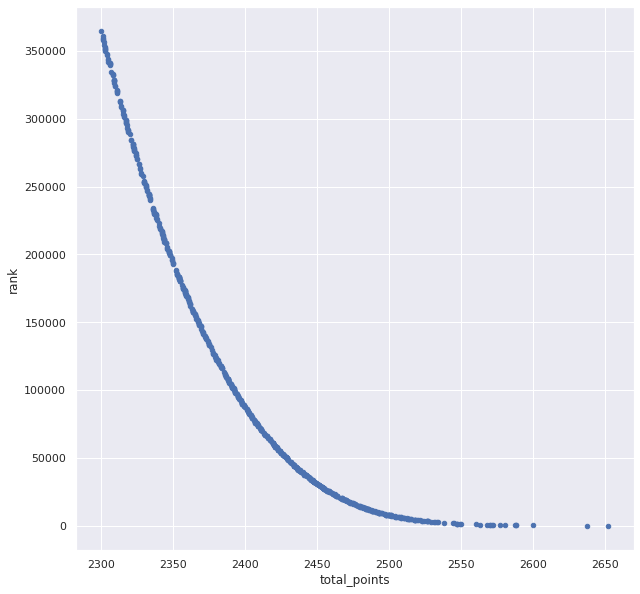

In [ ]:
import requests
import pandas as pd
import seaborn as sns
sns.set()

def Access_URL(url):
    r = requests.get(url) 
    json = r.json() 
    return json 


team_ids = range(1, 1000, 1)
overall_dataframe = pd.DataFrame()
for id in team_ids:
    previous_seasons = Access_URL(f'https://fantasy.premierleague.com/api/entry/{id}/history/')['past']
    df_player = pd.DataFrame(previous_seasons)
    df_player['id'] = id
    overall_dataframe = pd.concat([overall_dataframe, df_player])

last_season = overall_dataframe.loc[overall_dataframe['season_name'] == '2020/21']
last_season.plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))

# %%
mask = last_season['total_points'] >= 2300
last_season.loc[mask].plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))

# # %%
mask = (last_season['total_points'] >= 2300) & (last_season['total_points'] <= 2400)
# last_season.loc[mask].plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))

In [ ]:
last_season[last_season['total_points'] == 2244] # Without wildcards -- 2245
# Ranked in Top 640 000 playuers

,season_name,total_points,rank,id
13,2020/21,2244.0,638151.0,226
5,2020/21,2244.0,638403.0,862


In [ ]:
last_season[last_season['total_points'] == 2376] # With all chips -- 2376
print(f'Approximately: {round(131932.0/8e6*100, 3)}th percentile')

Approximately: 1.649th percentile
